In [ ]:
from typing import Optional

import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import pickle
from collections import defaultdict

from pathlib import Path
from data_generation.spectral_density import arma_spectral_density

from lrv_test import LRV
from lrv_test.types import real_function

from data_generation.arma import generate_arma_sample

import seaborn as sns

sns.set_style("whitegrid")

# Limit distribution check

In [2]:
def run(
    f: real_function,
    N: int,
    M: int,
    B: int,
    ar: float,
    ma: float,
    freqs: np.ndarray,
    is_complex_gaussian: bool,
    oracle_sd: Optional[real_function] = None,
    L: Optional[int] = None,
) -> dict:
    y = generate_arma_sample(N, M, ar, ma, is_complex_gaussian)
    lrv = LRV(y, B, f, freqs=freqs, L=L, sd=oracle_sd)
    return {
        "lrv": lrv,
        "freqs": freqs,
        "ar": ar,
        "ma": ma,
        "N": N,
        "M": M,
        "B": B,
        "is_complex_gaussian": is_complex_gaussian,
        # "oracle_sd": oracle_sd,
        "L": L,
    }

In [3]:
N_range = [1_000, 2_000, 5_000, 10_000]
alpha_range = np.arange(0.5, 1.0, 0.025)
c = 1 / 2

is_oracle_range = [True]  # [False, True]
is_complex_gaussian_range = [True]  # [False, True]

# Define the function / frequencies to test
f = lambda x: (x - 1) ** 2


def freqs(B, N):
    return None
    # return np.array([0, 0.1, 0.2, 0.4])[:2]
    # return np.arange(-0.4, 0.6, B / N)


# Define once properties of the arma process to generate
ar, ma = 0.1, 0.5

# Define the number of repetitions
n_repeat = 10**1

# storage path
storage_path = Path("./plots/clt_arma_large_alpha_nu")
storage_path.mkdir(parents=True, exist_ok=True)

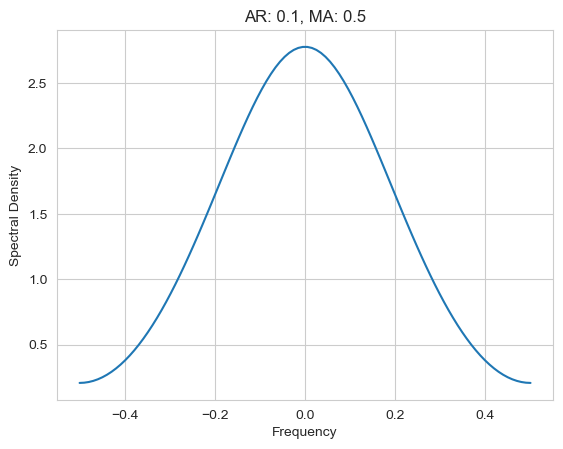

In [4]:
# plot arma spectral density
def plot_arma_sd(ar, ma):
    freqs = np.linspace(-0.5, 0.5, 100)
    sd_fun = arma_spectral_density(ar, ma)
    sd = sd_fun(freqs)
    plt.plot(freqs, sd)
    plt.title(f"AR: {ar}, MA: {ma}")
    plt.xlabel("Frequency")
    plt.ylabel("Spectral Density")


plot_arma_sd(ar, ma)

In [ ]:
tasks = defaultdict(list)

for is_oracle in is_oracle_range:
    for is_complex_gaussian in is_complex_gaussian_range:
        for N in N_range:
            if is_oracle:
                oracle_sd = arma_spectral_density(ar, ma)
                L = None
            else:
                oracle_sd = None
                L = int(N**0.15)

            for alpha in alpha_range:
                M = int(N**alpha)
                B = int(M / c)
                if B % 2 == 0:
                    B += 1

                if B > N:
                    continue

                freqs_values = freqs(B, N)

                task = {
                    "f": f,
                    "freqs": freqs_values,
                    "N": N,
                    "M": M,
                    "B": B,
                    "ar": ar,
                    "ma": ma,
                    "is_complex_gaussian": is_complex_gaussian,
                    "oracle_sd": oracle_sd,
                    "L": L,
                }
                tasks[N] += [task.copy() for _ in range(n_repeat)]

len(tasks)

4

In [6]:
results = []
N0, M0, B0 = (
    N_range[0],
    int(N_range[0] ** alpha_range[0]),
    int(N_range[0] ** alpha_range[0] / c),
)
for N, task_list in tasks.items():
    # can run 10 tasks for small N, decrase as a factor of N*M
    # function: 10/(N * M)[0]
    M = task_list[0]["M"]
    B = task_list[0]["B"]
    n_cpus = int(25 * (B0 * M0 / (B * M)))
    n_cpus = max(1, n_cpus)
    n_cpus = min(10, n_cpus)
    print(
        f"Running {len(task_list)} tasks with {n_cpus} cpus: {N}, {M}, {B}, {N0}, {M0}, {B0}"
    )
    results += Parallel(n_jobs=n_cpus)(delayed(run)(**task) for task in tqdm(task_list))

# save the results with pickle
with open(storage_path / "results.pkl", "wb") as f:
    pickle.dump(results, f)

# results = Parallel(n_jobs=1)(delayed(run)(**task) for task in tqdm(tasks))

Running 160 tasks with 10 cpus: 1000, 31, 63, 1000, 31, 63


  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [00:06<00:00, 24.85it/s]


Running 170 tasks with 10 cpus: 2000, 44, 89, 1000, 31, 63


 71%|███████   | 120/170 [00:01<00:00, 59.16it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x109423380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 82%|████████▏ | 140/170 [00:02<00:00, 37.54it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x107863380>
Traceback (most re

Running 170 tasks with 4 cpus: 5000, 70, 141, 1000, 31, 63


  0%|          | 0/170 [00:00<?, ?it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x10a163380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x111a63380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiproce

Running 170 tasks with 2 cpus: 10000, 100, 201, 1000, 31, 63


  0%|          | 0/170 [00:00<?, ?it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x10479b380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f63380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiproce

In [38]:
# load results from pickle
with open(storage_path / "results.pkl", "rb") as f:
    results = pickle.load(f)

In [52]:
expanded_results = []

for result in results:
    lrv = result["lrv"]
    freqs_values = np.array(result["lrv"].freqs)
    ar = result["ar"]
    ma = result["ma"]
    N = result["N"]
    M = result["M"]
    B = result["B"]
    is_complex_gaussian = result["is_complex_gaussian"]
    # oracle_sd = result["oracle_sd"]
    L = result["L"]

    is_oracle = oracle_sd is not None

    # re-estimate alpha: round alpha to the closest in the alpha_range
    alpha = np.log(M) / np.log(N)
    min_idx = np.argmin(np.abs(alpha_range - alpha))
    alpha = alpha_range[min_idx]

    for t_stat in ["t_stats_0", "t_stat_1", "t_stat_2", "t_stat_3", "t_stat_4"]:
        if t_stat == "t_stats_0":
            for i, nu in enumerate(freqs_values):
                expanded_result = {
                    "lrv": getattr(lrv, t_stat)[i],
                    "lrv_stat": t_stat,
                    "freq": freqs_values[i],
                    "ar": ar,
                    "ma": ma,
                    "N": N,
                    "M": M,
                    "B": B,
                    "is_complex_gaussian": is_complex_gaussian,
                    "is_oracle": is_oracle,
                    "alpha": alpha,
                }
                expanded_results.append(expanded_result)
        else:
            expanded_result = {
                "lrv": getattr(lrv, t_stat),
                "lrv_stat": t_stat,
                "freq": None,
                "ar": ar,
                "ma": ma,
                "N": N,
                "M": M,
                "B": B,
                "is_complex_gaussian": is_complex_gaussian,
                "is_oracle": is_oracle,
                "alpha": alpha,
            }
            expanded_results.append(expanded_result)

df = pd.DataFrame(expanded_results)

In [53]:
# select the 10 most frequent frequencies, round the frequencies to 2 decimal places
df["freq"] = df["freq"].round(2)
freqs, counts = np.unique(df["freq"], return_counts=True)
sorted_freqs, sorted_counts = zip(
    *sorted(zip(freqs, counts), key=lambda x: x[1], reverse=True)
)
selected_freqs = sorted_freqs[:25]
df = df[df["freq"].isin(selected_freqs)]

101.44930975972811
Frequency: -0.50, Number of rows: 670
-0.7601927187575915
Frequency: -0.37, Number of rows: 110
-1.4948105585549372
Frequency: -0.34, Number of rows: 100
-1.8240390399784818
Frequency: -0.30, Number of rows: 110
-2.540204600643701
Frequency: -0.25, Number of rows: 140
-1.28232878519744
Frequency: -0.20, Number of rows: 100
-3.9741935579327565
Frequency: -0.18, Number of rows: 110
-0.05999353038940053
Frequency: -0.12, Number of rows: 130
-2.413922370703254
Frequency: -0.10, Number of rows: 110
0.2508442203765751
Frequency: -0.06, Number of rows: 90
0.20234718110115305
Frequency: -0.02, Number of rows: 120
9.431007983831574
Frequency: 0.00, Number of rows: 110
3.1780653279560838
Frequency: 0.06, Number of rows: 90
-0.8688884675284589
Frequency: 0.10, Number of rows: 150
-41.809580278911625
Frequency: 0.13, Number of rows: 100
-10.14429763221363
Frequency: 0.14, Number of rows: 90
0.10476380208648427
Frequency: 0.20, Number of rows: 90
-3.274653045815001
Frequency: 0.2

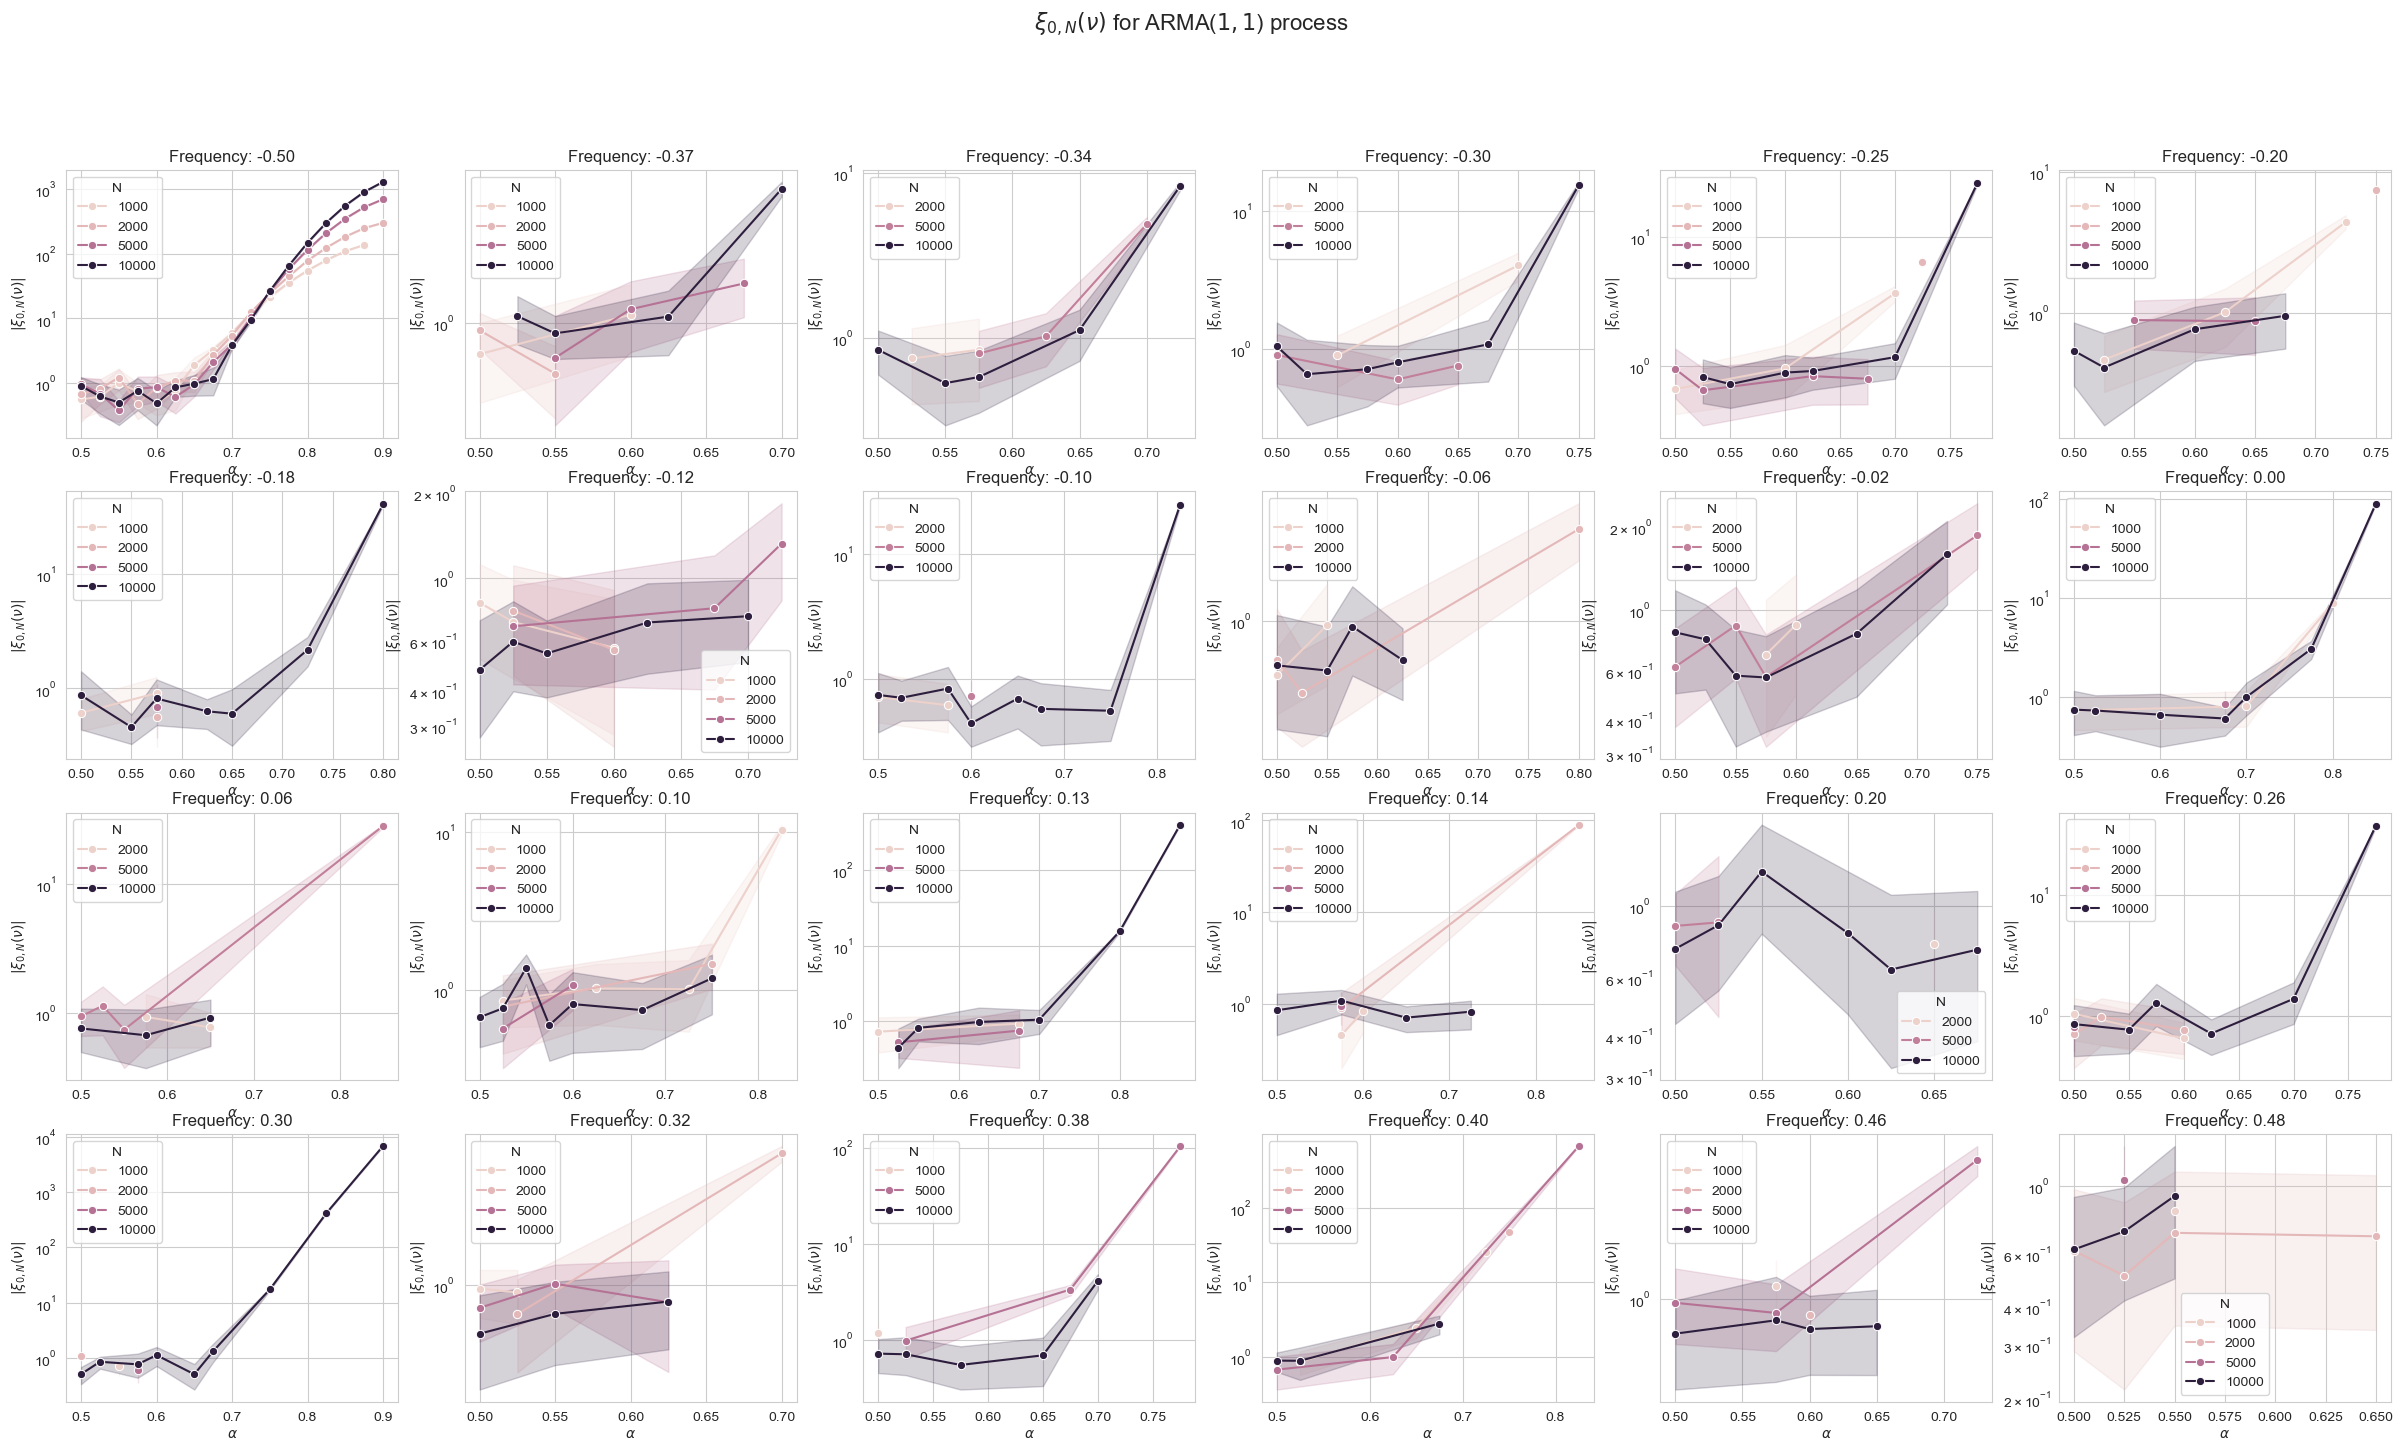

In [55]:
unique_freqs = sorted(df["freq"].unique())
n_freqs = len(unique_freqs)
sqrt_n_freqs = int(np.sqrt(n_freqs))
n_cols = int(np.ceil(n_freqs / sqrt_n_freqs))
n_rows = int(np.ceil(n_freqs / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
fig.suptitle(r"$\xi_{0,N}(\nu)$ for ARMA($1,1$) process", fontsize=16)
axs = axs.flatten()

for i in range(n_freqs):
    freq_value = unique_freqs[i]
    ax = axs[i]

    sub_df = df[df["freq"] == freq_value]

    sub_df = sub_df[sub_df["lrv_stat"] == "t_stats_0"]
    sub_df = sub_df[sub_df["is_oracle"] == True]
    sub_df = sub_df[sub_df["is_complex_gaussian"] == True]

    sns.lineplot(
        sub_df[["alpha", "lrv", "is_complex_gaussian", "N"]].abs(),
        x="alpha",
        y="lrv",
        hue="N",
        errorbar=("ci", 95),
        marker="o",
        ax=ax,
    )

    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$|\xi_{0,N}(\nu)|$")

    ax.set_yscale("log")
    ax.set_title(f"Frequency: {freq_value:.2f}")

    n_rows_for_freq = df[df["freq"] == freq_value].shape[0]
    print(f"Frequency: {freq_value:.2f}, Number of rows: {n_rows_for_freq}")

# save fig
fig.savefig(storage_path / "clt_arma_large_alpha.png")

In [24]:
expanded_results = []

for result in results:
    lrv = result["lrv"]
    freqs_values = result["freqs"]
    ar = result["ar"]
    ma = result["ma"]
    N = result["N"]
    M = result["M"]
    B = result["B"]
    is_complex_gaussian = result["is_complex_gaussian"]
    # oracle_sd = result["oracle_sd"]
    L = result["L"]

    is_oracle = oracle_sd is not None

    alpha = np.log(M) / np.log(N)
    # round alpha to the closest in the alpha_range
    min_idx = np.argmin(np.abs(alpha_range - alpha))
    alpha = alpha_range[min_idx]

    expanded_result = {
        "lrv": lrv.t_stat_1,
        "lrv_stat": "t_stat_1",
        "ar": ar,
        "ma": ma,
        "N": N,
        "M": M,
        "B": B,
        "is_complex_gaussian": is_complex_gaussian,
        "is_oracle": is_oracle,
        "alpha": alpha,
    }
    expanded_results.append(expanded_result)

df = pd.DataFrame(expanded_results)

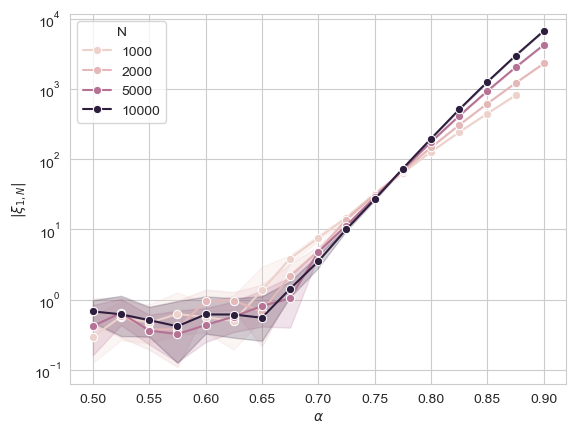

In [25]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_yscale("log")

sub_df = df[df["lrv_stat"] == "t_stat_1"]
sub_df = sub_df[sub_df["is_oracle"] == True]
sub_df = sub_df[sub_df["is_complex_gaussian"] == True]

sns.lineplot(
    sub_df[["alpha", "lrv", "is_complex_gaussian", "N"]].abs(),
    x="alpha",
    y="lrv",
    hue="N",
    errorbar=("ci", 95),
    marker="o",
    ax=ax,
)

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$|\xi_{1,N}|$")

# save fig
fig.savefig(storage_path / "clt_arma_large_alpha.png")